# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant business. Specifically, this report will be targeted to stakeholders interested in opening a **Fast Food Activity** in **Roma**, Italy.

Roma is one of the most visited cities in the world, and near the center there are a great number of monuments and historical places that attract million of tourists every year. The objective of the study is to find **locations that are not already crowded with restaurants** and that are close to this touristic attractions. In particular the interest is in **areas with no Fast Food in vicinity**, since (in my opinion) this is the best choice to attract potential clients.

I will use data science to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to fast foods in the neighborhood, if any
* distance of neighborhood from the touristic attractions defined

I decided to use some of the most visited places/monuments in Roma as starting point for the study.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be extracted from an excel database, previously created collecting the data using **Google Maps**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

### Import of relevant libraries 

Let's first import/install all the relevant libraries for the project

In [1]:
CLIENT_ID = 'H2GUAS5FKZBQ1INIZP3N3M5TP4CNQBHBU0BA35EG0ADI12EN' # your Foursquare ID
CLIENT_SECRET = 'NTD2K241LXVMZNQPIKRTMZNO4UKDNCKATFOWNCXI1DYTVGM0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
radius = 1000

In [13]:
#import relevant libraries
import pandas as pd
import numpy as np

import requests

In [2]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj

import math

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-

Let's use the geopy library to get the geographical coordinates of Roma

In [3]:
address = 'Roma, IT'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
Roma_lat = location.latitude
Roma_lng = location.longitude
print('The geograpical coordinatea of Roma are {}, {}.'.format(Roma_lat, Roma_lng))
print(location)

The geograpical coordinatea of Rome are 41.8933203, 12.4829321.
Roma, Roma Capitale, Italia


Definition of functions to convert from Latitude, Longitude Coordinates to UTM

In [4]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Roma center longitude={}, latitude={}'.format(Roma_lat, Roma_lng))
x, y = lonlat_to_xy(Roma_lat, Roma_lng)
print('Roma center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Roma center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Roma center longitude=41.8933203, latitude=12.4829321
Roma center UTM X=3524922.5699375295, Y=1542373.5657564667
Roma center longitude=41.89332029999999, latitude=12.4829321


In [93]:
roma_center_x = x
roma_center_y = y

Let's use the Folium libarary to plot a map of Rome

In [92]:
roma_center = [Roma_lat, Roma_lng]
map_roma = folium.Map(location=[Roma_lat, Roma_lng], zoom_start=13)
folium.Marker([Roma_lat, Roma_lng], popup='Roma Center').add_to(map_roma)

map_roma

Let's use an excel file created using google maps, to load the location of the **most visited places in Roma**

In [15]:
most_visited_places = pd.read_excel('Most visited places in Roma.xlsx', header=[0])
most_visited_places

,Name,Latitude,Longitude
0,Colosseo,41.890175,12.492237
1,Fontana di trevi,41.900962,12.483329
2,Pantheon,41.898606,12.476833
3,Piazza di Spagna,41.905746,12.482278
4,Piazza Navona,41.899116,12.473084
5,Altare della patria,41.894575,12.483025
6,Foro Romano,41.892477,12.485083
7,Castel Sant'Angelo,41.902984,12.466278
8,Ara Pacis,41.905826,12.475400
9,Piramide Cestia,41.876452,12.480910


In [17]:
X = []
Y= []
for ind in most_visited_places.index: 
    x, y = lonlat_to_xy(most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind])
    X.append(x)
    Y.append(y)
    lo, la = xy_to_lonlat(x, y)

In [18]:
most_visited_places.insert(3, "X", X, True) 
most_visited_places.insert(4, "Y", Y, True)
most_visited_places

,Name,Latitude,Longitude,X,Y
0,Colosseo,41.890175,12.492237,3.524418e+06,1.543473e+06
1,Fontana di trevi,41.900962,12.483329,3.525838e+06,1.542523e+06
2,Pantheon,41.898606,12.476833,3.525642e+06,1.541696e+06
3,Piazza di Spagna,41.905746,12.482278,3.526429e+06,1.542458e+06
4,Piazza Navona,41.899116,12.473084,3.525753e+06,1.541243e+06
5,Altare della patria,41.894575,12.483025,3.525072e+06,1.542402e+06
6,Foro Romano,41.892477,12.485083,3.524792e+06,1.542626e+06
7,Castel Sant'Angelo,41.902984,12.466278,3.526311e+06,1.540459e+06
8,Ara Pacis,41.905826,12.475400,3.526531e+06,1.541615e+06
9,Piramide Cestia,41.876452,12.480910,3.522918e+06,1.541903e+06


In [19]:
most_visited_places.to_pickle('./most_visited_locations.pkl')

In [22]:
#define a numpy array with the UTM coordinates of the different points of interest
x_coor = np.array(most_visited_places['X'])
y_coor = np.array(most_visited_places['Y'])

#define a numpy array with the lat,long coordinates of the different points of interest
latitudes = most_visited_places['Latitude']
longitudes = most_visited_places['Longitude']

Let's plot the map of Roma with superimposed the **location of the points of interest** (the monuments/sites that I choose as a reference)

In [23]:
for ind in most_visited_places.index: 
    label, lat, lng = [most_visited_places['Name'][ind], most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind]] 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

### Foursquare
Now that we have our location candidates, let's use **Foursquare API** to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, and we'll make sure to detect and include all the subcategories of specific 'Fast Food' category, as we need info on Fast Foods in the neighborhood.

In [24]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues
fast_food_categories = ['4bf58dd8d48988d16e941735', '4bf58dd8d48988d1df931735', '4bf58dd8d48988d16c941735',
             '56aa371be4b08b9a8d57350b', '4bf58dd8d48988d1cb941735', '4d4ae6fc7a7b7dea34424761',
             '4bf58dd8d48988d1c7941735']
# Category IDs corresponding to Fast Foods were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):


def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse', 'fast_food']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', Italia', '')
    address = address.replace(' Roma Lazio', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [25]:
import pickle

def get_restaurants(lats, lons):
    restaurants = {}
    fast_foods = {}
    location_restaurants = []
    print('Obtaining venues around candidate locations:', end='')

    for lat, lon in zip(lats, lons):

        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, CLIENT_ID, CLIENT_SECRET, radius=500, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_fast_food = is_restaurant(venue_categories, specific_filter=fast_food_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_fast_food, x, y)
                if venue_distance<=500:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_fast_food:
                     fast_foods[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, fast_foods, location_restaurants

# Try to load from local file system in case we did this before
restaurants = {}
fast_foods = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_500.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('fast_foods_500.pkl', 'rb') as f:
         fast_foods = pickle.load(f)
    with open('location_restaurants_500.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, fast_foods, location_restaurants = get_restaurants(latitudes, longitudes)
    
    # Let's persists this in local file system
    with open('restaurants_500.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('fast_foods_500.pkl', 'wb') as f:
        pickle.dump(fast_foods, f)
    with open('location_restaurants_500.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)

Restaurant data loaded.


In [26]:
import numpy as np

print('Total number of restaurants:', len(restaurants))
print('Total number of fast foods:', len(fast_foods))
print('Percentage of Fast Foods: {:.2f}%'.format(len(fast_foods) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

Total number of restaurants: 345
Total number of fast foods: 16
Percentage of Fast Foods: 4.64%
Average number of restaurants in neighborhood: 35.07142857142857


In [20]:
print('List of all restaurants')
print('-----------------------')
for r in list(restaurants.values())[:10]:
    print(r)
print('...')
print('Total:', len(restaurants))

List of all restaurants
-----------------------
('4ecae70c29c26a62837ffca2', 'Caffè Propaganda', 41.88827028265661, 12.494144647041766, 'Via Claudia, 15-19 (Via Marco Aurelio), 00184', 264, False, 292101.0775927139, 4640407.607971068)
('54ef5368498ea7bb960e8fdf', 'Pane & Vino', 41.88909392690291, 12.495328187942505, 'Via Ostilla 10, 00184', 283, False, 292201.9483486215, 4640496.195364506)
('4c6a2b842c29d13a6e3a0d41', 'Aroma', 41.890164189913804, 12.495598765282805, 'Palazzo Manfredi (Via Labicana, 125), 00184', 278, False, 292227.86873804434, 4640614.3799850065)
('4beef98a6faac9b6899fa9c6', 'Naumachia', 41.88912, 12.49668, 'Via Celimontana, 7, 00184', 386, False, 292314.1926893038, 4640495.815547878)
('4ec414b84901dfe99c1bbc93', 'Crab', 41.88911048939818, 12.494093452463366, "Via Capo D'Africa 2,", 194, False, 292099.55608982354, 4640501.027282673)
('4e18b89bd22d512258867832', 'Ristorante Valentino', 41.89378099646984, 12.489750369286773, 'Via Cavour, 293,', 358, False, 291754.3917265

In [21]:
print('List of Fast Foods')
print('---------------------------')
for r in list(fast_foods.values())[:10]:
    print(r)
print('...')
print('Total:', len(fast_foods))

List of Fast Foods
---------------------------
('5b09c045012358002cbeb6fa', "McDonald's", 41.90251664106887, 12.48406927733652, 'Via del Tritone 58, 00187', 388, True, 291311.52859482914, 4642013.979395754)
('4e5e0cb37d8b67dc8fedec3f', 'Bar Gambero', 41.90343260530381, 12.480198435402531, 'Via Gambero 40 (Via della Vite),', 378, True, 290993.4212117151, 4642125.11699779)
('59901b55d807ee5ed156d593', 'T-Burger Station', 41.898276, 12.476266, '00186', 279, True, 290650.36519959825, 4641562.129123519)
('5183d8fa498efa9faffdf41c', "Caffe' Ristorante", 41.90909653737132, 12.478307706206534, 'Italia', 436, True, 290855.0820897843, 4642758.644680892)
('4c57fea02308be9a144a5a6c', 'Burger King', 41.89727768032902, 12.487838639381286, 'Via Nazionale, 178, 00184', 499, True, 291607.16240015766, 4641423.0835509645)
('5b684389464d65002c3c815a', 'Grano La Cucina Di Traiano', 41.896122, 12.485359, '00187', 495, True, 291397.6894626182, 4641300.7884603385)
('5a8eb9e5dee7702970a2d70b', 'Pasta In Corso'

In [22]:
print('Restaurants around location')
print('---------------------------')
for i in range(0, 14):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Restaurants around location
---------------------------
Restaurants around location 1: Caffè Propaganda, Pane & Vino, Aroma, Naumachia, Crab, Ristorante Valentino, All Bi One, La Base
Restaurants around location 2: La Prosciutteria, Il Piccolo Buco, Sant'Andrea, Vineria Il Chianti, Fontana di Venere, Angelina a Trevi, Temakinho, Up Sunset Bar
Restaurants around location 3: Capranica Enoteca & Taverna, Armando al Pantheon, La Ciambella, Locanda del Prosciutto, Sapore di Mare, Antica Trattoria da Pietro al Pantheon, La Rosetta, La Sacrestia
Restaurants around location 4: Hosteria del Mercato 1870, Ristorante Mario, Sant'Andrea, Dillà, Le Sorelle, Hamasei, Tartufi & Friends, cantina belsiana
Restaurants around location 5: Pietro Valentini Ristorante, Osteria Del Pegno, Ristorante Fiammetta, Cantina e Cucina, Da Simo, I Pizzicaroli, SeC Sedie E Cantine, solo Gastronomia & vineria
Restaurants around location 6: La Cabana, Edoardo II, Locanda del Prosciutto, Sapore di Mare, La Taverna dei Fo

Let's now see all the collected restaurants in our areas of interest on map, and let's also show Fast Foods in different color (red).

In [88]:
map_roma = folium.Map(location=roma_center, zoom_start=13)
folium.Marker(roma_center, popup='Alexanderplatz').add_to(map_roma)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_fastfood = res[6]
    color = 'red' if is_fastfood else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_roma)
map_roma

for ind in most_visited_places.index: 
    label, lat, lng = [most_visited_places['Name'][ind], most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind]] 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

## Methodology <a name="methodology"></a>

In this project I will direct my efforts on detecting areas of Roma, near to the points of interest (PoI), that have low restaurant density, particularly those with low number of Fast Foods activities. I will limit our analysis to area ~0.5km around the points of interest.

In the previous step I have collected the required **data: location and type (category) of every restaurant within 0.5km from the points of interest**. I have also **identified Fast Food Activities** (according to Foursquare categorization).

Second step in this analysis will be calculation and exploration of '**restaurant density**' across different areas of Roma - I will use **heatmaps** to identify a few promising areas close to PoI with low number of restaurants in general (*and* no Fast Foods in vicinity) and focus my attention on those areas.

In third and final step I will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: I will take into consideration locations with **no more than two restaurants in radius of 250 meters**, and I want locations **without Fast Foods in radius of 200 meters**. I will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:

In [32]:
location_restaurants_count = [len(res) for res in location_restaurants]

most_visited_places['Restaurants in area'] = location_restaurants_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_restaurants_count).mean())

most_visited_places

Average number of restaurants in every area with radius=300m: 35.07142857142857


,Name,Latitude,Longitude,X,Y,Restaurants in area
0,Colosseo,41.890175,12.492237,3.524418e+06,1.543473e+06,19
1,Fontana di trevi,41.900962,12.483329,3.525838e+06,1.542523e+06,69
2,Pantheon,41.898606,12.476833,3.525642e+06,1.541696e+06,65
3,Piazza di Spagna,41.905746,12.482278,3.526429e+06,1.542458e+06,51
4,Piazza Navona,41.899116,12.473084,3.525753e+06,1.541243e+06,69
5,Altare della patria,41.894575,12.483025,3.525072e+06,1.542402e+06,28
6,Foro Romano,41.892477,12.485083,3.524792e+06,1.542626e+06,21
7,Castel Sant'Angelo,41.902984,12.466278,3.526311e+06,1.540459e+06,31
8,Ara Pacis,41.905826,12.475400,3.526531e+06,1.541615e+06,45
9,Piramide Cestia,41.876452,12.480910,3.522918e+06,1.541903e+06,24


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [34]:
distances_to_fast_food = []

for area_x, area_y in zip(x_coor, y_coor):
    min_distance = 10000
    for res in fast_foods.values():
        t_res_x = res[2]
        t_res_y = res[3]
        res_x, res_y = lonlat_to_xy(t_res_x, t_res_y)
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_fast_food.append(min_distance)


most_visited_places.insert(5, "Distance to nearest Fast Food", distances_to_fast_food, True)
most_visited_places

,Name,Latitude,Longitude,X,Y,Distance to nearest Fast Food,Restaurants in area
0,Colosseo,41.890175,12.492237,3.524418e+06,1.543473e+06,1017.545073,19
1,Fontana di trevi,41.900962,12.483329,3.525838e+06,1.542523e+06,209.402636,69
2,Pantheon,41.898606,12.476833,3.525642e+06,1.541696e+06,80.571715,65
3,Piazza di Spagna,41.905746,12.482278,3.526429e+06,1.542458e+06,380.060820,51
4,Piazza Navona,41.899116,12.473084,3.525753e+06,1.541243e+06,405.502100,69
5,Altare della patria,41.894575,12.483025,3.525072e+06,1.542402e+06,267.933782,28
6,Foro Romano,41.892477,12.485083,3.524792e+06,1.542626e+06,443.100009,21
7,Castel Sant'Angelo,41.902984,12.466278,3.526311e+06,1.540459e+06,528.343795,31
8,Ara Pacis,41.905826,12.475400,3.526531e+06,1.541615e+06,464.537943,45
9,Piramide Cestia,41.876452,12.480910,3.522918e+06,1.541903e+06,380.191968,24


Let's sort the data using the number of Restaurants in a specific area

In [35]:
most_visited_places_sorted = most_visited_places.sort_values(by=['Restaurants in area'])
most_visited_places_sorted

,Name,Latitude,Longitude,X,Y,Distance to nearest Fast Food,Restaurants in area
10,Terme di Caracalla,41.879018,12.492397,3.523072e+06,1.543345e+06,1191.732367,2
11,Circo Massimo,41.886608,12.484906,3.524087e+06,1.542527e+06,169.105255,10
13,Tempio di Giove,41.892400,12.482088,3.524823e+06,1.542258e+06,528.441028,12
0,Colosseo,41.890175,12.492237,3.524418e+06,1.543473e+06,1017.545073,19
6,Foro Romano,41.892477,12.485083,3.524792e+06,1.542626e+06,443.100009,21
9,Piramide Cestia,41.876452,12.480910,3.522918e+06,1.541903e+06,380.191968,24
5,Altare della patria,41.894575,12.483025,3.525072e+06,1.542402e+06,267.933782,28
7,Castel Sant'Angelo,41.902984,12.466278,3.526311e+06,1.540459e+06,528.343795,31
8,Ara Pacis,41.905826,12.475400,3.526531e+06,1.541615e+06,464.537943,45
12,Mercato di Traiaino,41.895628,12.486204,3.525157e+06,1.542805e+06,120.204046,45


In [36]:
res_area = most_visited_places_sorted[['Name', 'Distance to nearest Fast Food' , 'Restaurants in area']]
res_area.reset_index(drop=True, inplace=True)
res_area

,Name,Distance to nearest Fast Food,Restaurants in area
0,Terme di Caracalla,1191.732367,2
1,Circo Massimo,169.105255,10
2,Tempio di Giove,528.441028,12
3,Colosseo,1017.545073,19
4,Foro Romano,443.100009,21
5,Piramide Cestia,380.191968,24
6,Altare della patria,267.933782,28
7,Castel Sant'Angelo,528.343795,31
8,Ara Pacis,464.537943,45
9,Mercato di Traiaino,120.204046,45


Let's plot a histrogram of the number of restaurants and minimum distance from each PoI

[Text(0, 0, 'Terme di Caracalla'),
 Text(0, 0, 'Circo Massimo'),
 Text(0, 0, 'Tempio di Giove'),
 Text(0, 0, 'Colosseo'),
 Text(0, 0, 'Foro Romano'),
 Text(0, 0, 'Piramide Cestia '),
 Text(0, 0, 'Altare della patria'),
 Text(0, 0, "Castel Sant'Angelo"),
 Text(0, 0, 'Ara Pacis'),
 Text(0, 0, 'Mercato di Traiaino'),
 Text(0, 0, 'Piazza di Spagna'),
 Text(0, 0, 'Pantheon'),
 Text(0, 0, 'Fontana di trevi '),
 Text(0, 0, 'Piazza Navona')]

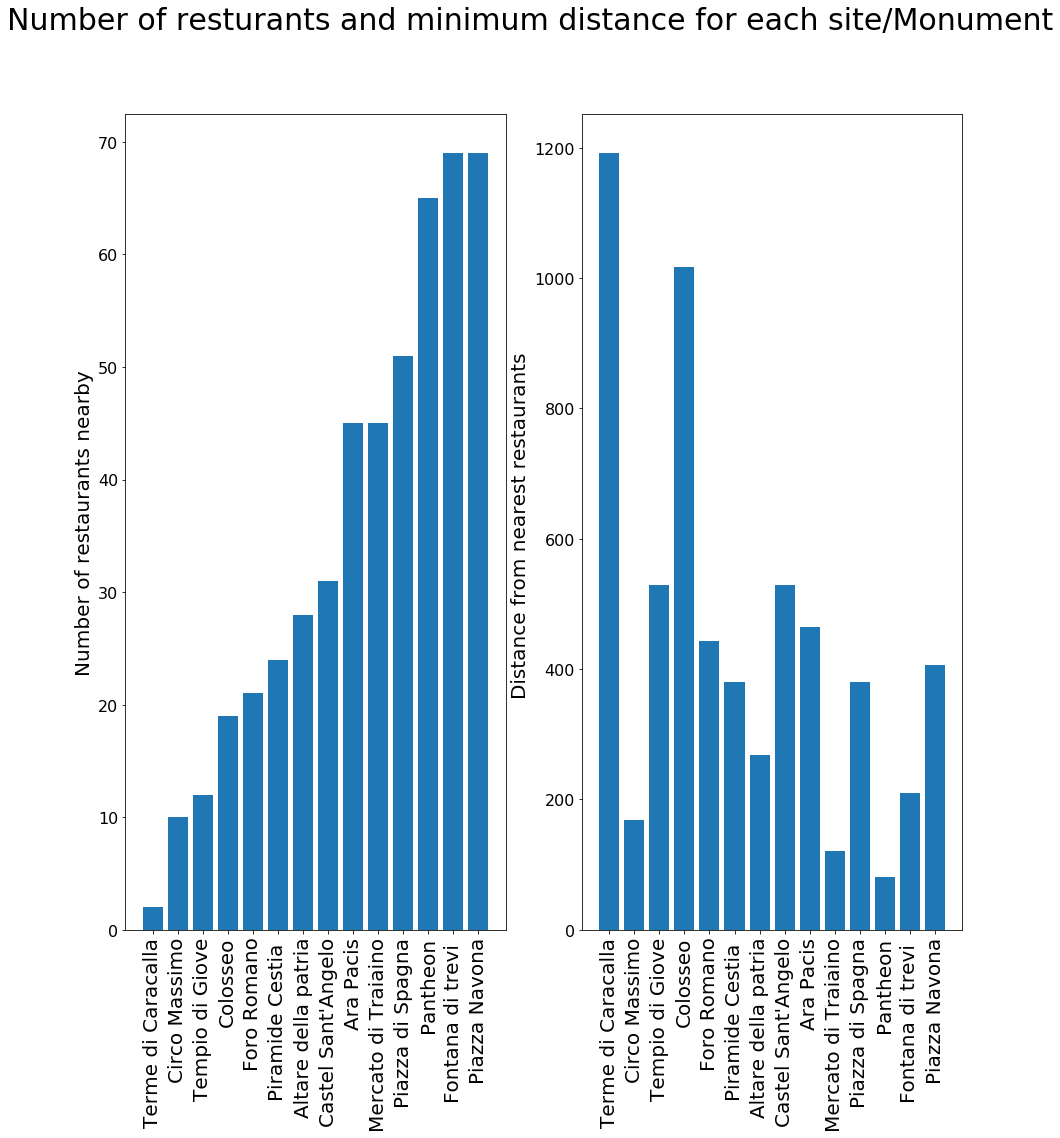

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
fig.suptitle('Number of resturants and minimum distance for each site/Monument', fontsize = 30)
ax1.bar(res_area['Name'], res_area['Restaurants in area'])
ax1.set_ylabel('Number of restaurants nearby', fontsize = 20.0, rotation=90)
ax2.bar(res_area['Name'], res_area['Distance to nearest Fast Food'])
ax2.set_ylabel('Distance from nearest restaurants ', fontsize = 20.0, rotation=90)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xticklabels(res_area['Name'],  fontsize = 20.0, rotation=90)
ax2.set_xticklabels(res_area['Name'],  fontsize = 20.0, rotation=90)

From this graph it is clear that the most promising area are the one around the _Terme di Caracalla_, the _Circo Massimo_, the _Tempio di Giove_ and the _Colosseo_

In [41]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

fastfood_latlons = [[res[2], res[3]] for res in fast_foods.values()]

Let's crete a map showing **heatmap / density of restaurants** and try to extract some meaningfull info from that. Also, let's show a few circles indicating distance of 1km, 2km and 3km from the city center.

In [95]:
from folium import plugins
from folium.plugins import HeatMap

map_roma = folium.Map(location=roma_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_roma) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_roma)
folium.Marker(roma_center).add_to(map_roma)
folium.Circle(roma_center, radius=1000, fill=False, color='white').add_to(map_roma)
folium.Circle(roma_center, radius=2000, fill=False, color='white').add_to(map_roma)
folium.Circle(roma_center, radius=3000, fill=False, color='white').add_to(map_roma)
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

for ind in most_visited_places.index: 
    label, lat, lng = [most_visited_places['Name'][ind], most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind]] 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

Let's crete a map showing **heatmap / density of Fast Foods** and try to extract some meaningfull info from that. Also, let's show a few circles indicating distance of 1km, 2km and 3km from the city center.

In [96]:
map_roma = folium.Map(location=roma_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_roma) #cartodbpositron cartodbdark_matter
HeatMap(fastfood_latlons).add_to(map_roma)
folium.Marker(roma_center).add_to(map_roma)
folium.Circle(roma_center, radius=1000, fill=False, color='white').add_to(map_roma)
folium.Circle(roma_center, radius=2000, fill=False, color='white').add_to(map_roma)
folium.Circle(roma_center, radius=3000, fill=False, color='white').add_to(map_roma)
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

for ind in most_visited_places.index: 
    label, lat, lng = [most_visited_places['Name'][ind], most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind]] 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

This map is not so 'hot' (Fast Foods represent a subset of ~5% of all restaurants in Roma) but it also indicates higher density of existing Fast Foods in the northern part of the maps, with closest pockets of **low Fast Foods density positioned in the southern part**.

Based on thismap,  the most promising areas are near to the **"Terme di Caracalla"**,  and between the **"Colosseo"** and the **"Circo Massimo"**.

Of course the zones around the _Colosseo_ and the _Circo Massimo_ are more interesting from the point of view of a potential stakeholder, since they are nearer to the city center and also because the **Colosseum is by far the most visited site in the city** (almost 7 million tourist in 2019).

In [64]:
roi_x_min = x_coor[11] 
roi_y_max = y_coor[11]
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min 
roi_center_y = roi_y_max 
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lon, roi_center_lat]
print(roi_center)

map_roma = folium.Map(location=roi_center, zoom_start=14)
HeatMap(restaurant_latlons).add_to(map_roma)
folium.Marker(roma_center).add_to(map_roma)
folium.Circle(roi_center, radius=500, color='white', fill=True, fill_opacity=0.4).add_to(map_roma)
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

for ind in most_visited_places.index: 
    label, lat, lng = [most_visited_places['Name'][ind], most_visited_places['Latitude'][ind], most_visited_places['Longitude'][ind]] 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

[41.886608, 12.484906]


In [78]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 50
y_step = 50 * k 
roi_y_min = roi_center_y - 750

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 751):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

409 candidate neighborhood centers generated.


In [79]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x, res_y = lonlat_to_xy(res[2], res[3])
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x, res_y = lonlat_to_xy(res[2], res[3])
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_fastfoods_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=500)
    roi_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, fast_foods)
    roi_fastfoods_distances.append(distance)
print('done.')

Generating data on location candidates... done.


In [80]:
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to fast food restaurant':roi_fastfoods_distances})

df_roi_locations

,Latitude,Longitude,X,Y,Restaurants nearby,Distance to fast food restaurant
0,12.479211,41.885972,3.524087e+06,1.541820e+06,1,706.856212
1,12.479166,41.886382,3.524137e+06,1.541820e+06,2,720.372577
2,12.479122,41.886792,3.524187e+06,1.541820e+06,3,737.039750
3,12.479078,41.887202,3.524237e+06,1.541820e+06,3,756.649547
4,12.479034,41.887612,3.524287e+06,1.541820e+06,3,778.979770
...,...,...,...,...,...,...
404,12.490112,41.889680,3.524387e+06,1.543206e+06,6,841.168187
405,12.490682,41.887669,3.524137e+06,1.543249e+06,3,773.641286
406,12.490638,41.888079,3.524187e+06,1.543249e+06,3,789.184252
407,12.490594,41.888489,3.524237e+06,1.543249e+06,3,807.528779


In [81]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_fastfood_distance = np.array(df_roi_locations['Distance to fast food restaurant']>=200)
print('Locations with no Fast foods within 400m:', good_fastfood_distance.sum())

good_locations = np.logical_and(good_res_count, good_fastfood_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]

Locations with no more than two restaurants nearby: 39
Locations with no Fast foods within 400m: 406
Locations with both conditions met: 39


In [82]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_roma = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_roma)
HeatMap(restaurant_latlons).add_to(map_roma)
folium.Circle(roi_center, radius=500, color='white', fill=True, fill_opacity=0.6).add_to(map_roma)
folium.Marker(roma_center).add_to(map_roma)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lon, lat], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_roma) 
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

In [86]:
from sklearn.cluster import KMeans

number_of_clusters = 6

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_roma = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_roma)
HeatMap(restaurant_latlons).add_to(map_roma)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_roma)
folium.Marker(roma_center).add_to(map_roma)
for lon, lat in cluster_centers:
    folium.Circle([lon, lat], radius=50, color='green', fill=True, fill_opacity=0.25).add_to(map_roma) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_roma)
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

In [87]:
map_roma = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(roma_center).add_to(map_roma)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lon, lat], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_roma)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lon, lat], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_roma)
for lon, lat in cluster_centers:
    folium.Circle([lon, lat], radius=50, color='green', fill=False).add_to(map_roma) 
#folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_roma)
map_roma

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Roma (~350 in our initial area of interest), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north from the city center, so we focused our attention to areas around the Colosseum and the Circo Massimo (excluding another potentially interesting area near the Terme di Caracalla becasue it is more far form the city center). The area selected is a very intersting one since the Colosseum is the most visited site in all Italy. and this alone grants a lot of potential clients in this area. 

After directing our attention to this more narrow area of interest, we first created a dense grid of location candidates (spaced 50m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Fast Foods activities closer than 200m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. in Particular two macroareas where identified, one on the _Lungotevere Aventino_ road and the other on _Via di San Gregorio_.

Result of all this is 5 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Fast Foods particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Rome's st famous monuments/sites, but not crowded with existing restaurants (particularly Fast foods) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Roma areas close to important monuments/sites with low number of restaurants (particularly Fast Foods) in order to aid stakeholders in narrowing down the search for optimal location for a new Fast Food activity. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (near the Colosseum and the Circo Massimo), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and the coordinates of those zone centers can then be used as starting points for final exploration by stakeholders.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.